In [121]:
from bs4 import BeautifulSoup
from itertools import chain
import matplotlib
from collections import Counter
from nltk.corpus import stopwords
import urllib
from lxml import html
import numpy as np
import requests
import pandas as pd
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import requests_cache
requests_cache.install_cache('demo_cache')
import math
from matplotlib import pyplot
import statsmodels
from scipy.interpolate import interp1d
import warnings
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import html2text
import urllib2
import re
import folium
import plotly.graph_objs as go
warnings.filterwarnings("ignore")
from IPython.display import HTML
matplotlib.style.use('ggplot')

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

![alt text](https://raw.githubusercontent.com/lizhihao1212/Final-Project/master/house.jpg)

# Introduction

## Background

When it comes to home, the word has many different meanings, like habitation or building. However, it has more significantly meanings for people, like family, assets and etc. In reality, many people would like to buy houses to have comfortable and sustainable places to live. Thus, in order to pay for houses, many people need to afford for their 'Mortgage Payments' which usually cost them 25 to 35 percentages of pretax incomes. Also, in most time, they are intutitively concerned about the price of housing. From the google trend, a particular search-term is entered relative to the total search-volume, we can see that from the trend of searching interests of house price slowly move up with time. This means more and more people increasingly focus on houses prices in recent years. In fact, the house prices are increasing nowadays. For example, the house prices of Davis dramatically increased from 2012 to 2017. Therefore, the change of house price happended in reality around us. 

Through simply searching on Google, we found a possible reason that might explain for the increasing of house price. Since year 2000, the 30-Year Fixed Rate Mortgage Average in the United States tend to decrease steadily, which could lead people to take actions on mortgaging their houses [rate](https://fred.stlouisfed.org/graph/?g=NUh). With increasing of demand, it will push the supply of house to increase. Thus, the house prices increase in recent years. 

For this project, we plan to predict the house price in California in 2017 and figure out more useful and possible reasons or factors which make the house prices increase. 

Google Trend
![alt text](https://raw.githubusercontent.com/lizhihao1212/Final-Project/master//trend.png)

Interest Rate
![alt text](https://raw.githubusercontent.com/lizhihao1212/Final-Project/master//rate.png)

![alt text](https://github.com/lizhihao1212/Final-Project/blob/master/WechatIMG3935.jpeg?raw=true)

# Methodology

1. Find the useful data sets for house prices from online. 

2. Fit Time series Model for house prices
  *  Diagnoistic for model
  *  Predict for house prices
  
3. Investiage the influential factors

## Data Source

To analyze the prices of houses and investage the possible influential factors, we will use data from the different websites:

1. We get different categories about the house prices by using API. [Zillow](https://blog.quandl.com/api-for-housing-data). 
2. The data of shopping malls in California. [Shopping malls](https://en.wikipedia.org/wiki/List_of_shopping_malls_in_California)
3. The company of top 500 [company]
(https://blog.quandl.com/api-for-housing-data). 
4. The data of Luxury Hotels [Hotel](http://www.luxurylink.com/inventory/main.php?kw=california&dtin=2017-04-05&dtout=2017-04-06&guests=2&nights=1&prc=&pmn=&pmx=&es=0&ot=&sort=r&pp=25&np=1&ev=0&&)
5. All avaiable universities in California. [College](http://www.4icu.org/us/california/universities-california.htm)
6. The income, population and population density of all counties in California from Wikipedia. [Wiki data](https://en.wikipedia.org/wiki/List_of_California_locations_by_income)




# Prediction
## Set up the model
### Strategy

We use time series model to predict the housing price of CA in 2017. We first use the first difference to detrend and then use the twelfth difference to deseaonality since we assume the seasonality is 12. Then we use the function " statsmodels.tsa.stattools.arma_order_select_ic" to select the best ARIMA Model.


### Diagnostic 

The orange line of the following plot shows the predict data and the blue line is the real data. The difference between these two lines are small, so we may assume our data is reliable

In [40]:
def find(state_code,par,par_1):
    '''
    Augument: 
        Given the state code, state and type of price to get the list of price from 1997 to 2017 .
        
    Input:
        the state code, state and type of price
        
    Output:
        list of price from 1997 to 2017
    
    '''
    url = 'http://www.quandl.com/api/v3/datasets/ZILL/'
    url = url+(par)+state_code + "_"+(par_1)
    response = requests.get(url)
    house_iv = response.json()
    house_iv = house_iv['dataset']['data']
    house_iv = pd.DataFrame(house_iv)
    return house_iv


def TimeSeries(ts):
    '''
    Augument: 
        Give the time series data and output the predict data .
        
    Input:
        Give the time series data
        
    Output:
       predict data 
    '''
    ts = ts.reindex(index=ts.index[::-1])
    ts.index = ts[0]
    ts.index = pd.to_datetime(ts.index)
    a = range(0,len(ts[0]))
    ts[0] = a
    result = []
    for i in ts[1]:
        i  = math.log(i)
        result.append(i)
    ts[1]  = result
    ts["firstdif"] = ts[1]-ts[1].shift(1)
    ts["seasondif"] = ts["firstdif"]-ts["firstdif"].shift(12)
    new_date_time = ts.copy()
    del ts[1]
    del ts['firstdif']
    del ts[0]
    ts= ts.dropna(inplace = False)
    res = statsmodels.tsa.stattools.arma_order_select_ic(ts, max_ar=4, max_ma=4, ic='bic', trend='c', model_kw={}, fit_kw={})
    ar = res.bic_min_order[0]
    ma = res.bic_min_order[1]
    model = ARIMA(ts,order = (ar,0,ma))
    model_fit = model.fit(disp = 0)
    forcast = model_fit.forecast(steps = 12)[0]
    new_date_time = new_date_time.dropna()
    new_res = []
    new_res_2 = []
    for i in range(0,12):
        new = forcast[i]+new_date_time["firstdif"][-12+i]
        new_res.append(new)
    
    tmp = new_res[0]+new_date_time[1][-1]
    new_res_1 = [tmp]
    for i in range(1,12):
          tmp = new_res[i]+tmp
          new_res_1.append(tmp)
    for i in new_res_1:
        new_2 = math.exp(i)
        new_res_2.append(new_2)
    return new_res_2,ar,ma

In [41]:
def Forecast(data):
    '''
    Augument: 
        Give the dataframe to get the residual .
        
    Input:
        Give the time series data
        
    Output:
       residual
    '''
    
    data_train = data.iloc[12::]
    test = TimeSeries(data_train)[0]
    data_test = pd.DataFrame((data.iloc[0:12][1]))
    data_test = data_test.reindex(index=data_test.index[::-1])
    data_test[0] = test
    data_test["res"] =  data_test[0]-data_test[1]
    del data_test[1]
    del data_test[0]
    return data_test

In [42]:
ca = find("00001","S","MVSF") #Find price per Square Foot in CA
ca_train = ca.iloc[12::] #Use the dataframe 1997 to 2015.12 as train data
test = (TimeSeries(ca_train)[0]) #use the data to predict the data in 2016

In [43]:
data_test = pd.DataFrame((ca.iloc[0:12][1])) #Get the real data from the dataset in 2016
data_test.reindex(index=data_test.index[::-1])
data_test[0] = test #add a cloumn of predict data

In [44]:
# get dataframe
ca_test = pd.DataFrame((ca.iloc[0:12][1]))
ca_test = ca_test.reindex(index=ca_test.index[::-1])
# add predict values
ca_test[0] = test
# rename
ca_test.columns = ['Real Data of Housing Price', 'Predict Data of Housing Price']
# reset index
ca_test = ca_test.reset_index().drop('index', 1)
# get the plot values
real = [str(i) for i in ca_test['Real Data of Housing Price']]
predict = [str(i) for i in test]
date = [str(i) for i in range(1,13)]


import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('lizhihao1212', 'fE8dxrbFxyY3AttQcxwU')
trace1 = {
  "x": date, 
  "y": real, 
  "marker": {"size": 8}, 
  "mode": "lines+markers", 
  "name": "Real Price [$]", 
  "type": "scatter", 
  "uid": "0f9fa6"
}
trace2 = {
  "x": date, 
  "y": predict, 
  "marker": {"size": 8}, 
  "mode": "lines+markers", 
  "name": "Predict Price [$]", 
  "type": "scatter", 
  "uid": "3fdd59"
}
data = Data([trace1, trace2])
layout = {
  "autosize": True, 
  "height": 553, 
  "title": "Real Price vs Predict Price", 
  "width": 847, 
  "xaxis": {
    "autorange": True, 
    "range": [1, 12], 
    "title": "Month", 
    "type": "linear"
  }, 
  "yaxis": {
    "autorange": True, 
    "range": [0, 550000], 
    "title": "Price [$]", 
    "type": "linear"
  }
}
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Predict the Price Per Square foot in CA, 2017

The following plot shows the predict price of the house price Per Square foot in 2017 and it is clear that the housing price keep increasing in 2017.

Moreover, the increase rate in Winter and spring are roughly the same and August to October have the largest increase rate

In [45]:
ca_dat = pd.DataFrame(TimeSeries(ca)[0]) #Use the model to predict the data in 2017
Mon = ["Feb","Mar","April","May","June","July","Aug","Sep","Oct","Nov","Dec","Jan"]
ca_dat["Mon"] = Mon #Get the predict dataset

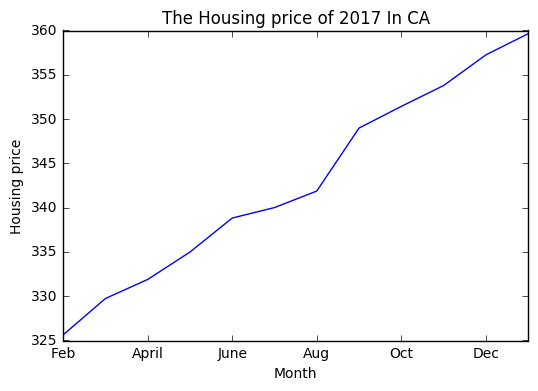

In [46]:
ca_dat.plot(x = "Mon",y = 0,kind = "line",legend = False) #plot the predict line
plt.xlabel("Month")
plt.ylabel("Housing price")
plt.title("The Housing price of 2017 In CA")
plt.show()

## Set up the model for the 14 Counties in CA

As mentioned in the introduction, we also interested in some large counties in CA. The Criterior we choose is according the population. The following image is the top 14 largest population in CA

![alt text](https://raw.githubusercontent.com/lizhihao1212/Final-Project/master/WechatIMG3933.jpeg
)

### Diagnostic

We use the same method in above to find the model and use the menu to get the difference between the predict data and real data of 14 Counties.

In [47]:
Final_res_co = []
Final_model_ar = []
Final_model_ma = []
fordata = Forecast(find("00001","CO","MVSF"))
Country = ["Los Angeles","San Diego","Orange","Riverside","Santa Clara","Sacramento","Fresno","San Francisco","Santa Barbara","Santa Cruz","Yolo","San Mateo","San Joaquin","Kern"]
resur_1 = []
for_dat = []
resur_1.extend(["00001","00004","00005","00010","00015","00022","00042","00060","00140","00221","00269","00073","00078","00056"])
for i in resur_1:
    ts = find(i,"CO","MVSF")
    forc = Forecast(ts)
    fordata[i] = forc 
    Final_res_co.append(sum(TimeSeries(ts)[0])/12)
    Final_model_ar.append(TimeSeries(ts)[1])
    Final_model_ma.append(TimeSeries(ts)[2])
del fordata["res"]

In [49]:
fordata.columns = Country

In [50]:
# Use the menu to get the plot
countries = ["jan","Feb","March","April","May","June","July","August","Sep","Oct","Nov","Dec"]
LA = list(fordata["Los Angeles"])
SD = list(fordata["San Diego"])
OR = list(fordata["Orange"])
RV = list(fordata["Riverside"])
SC = list(fordata["Santa Clara"])
SAC = list(fordata["Sacramento"])
Fres = list(fordata["Fresno"])
SF = list(fordata["San Francisco"])
SB = list(fordata["Santa Barbara"])
Santa_Cruz = list(fordata["Santa Cruz"])
Yolo = list(fordata["Yolo"])
San_Mateo = list(fordata["San Mateo"])
San_joaquin = list(fordata["San Joaquin"])
kern = list(fordata["Kern"])
trace1 = Scatter(
    x=countries, y=LA,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='LA'
)

trace2 = Scatter(
    x=countries, y = SD,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='SD'
)

trace3 = Scatter(
    x=countries, y=OR,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='OR'
)

trace4 = Scatter(
    x=countries, y=RV,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Riverside'
)

trace5 = Scatter(
    x=countries, y=SAC,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Sac'
)

trace6 = Scatter(
    x=countries, y = Fres,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Fresno'
)

trace7 = Scatter(
    x=countries, y=SF,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='San Francisco'
)

trace8 = Scatter(
    x=countries, y=SB,
    line=Line(
        color='#000000',
        width=4
    ),
    name='Santa Barbara'
)
trace9 = Scatter(
    x=countries, y=Santa_Cruz,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Santa Cruz'
)

trace10 = Scatter(
    x=countries, y = Yolo,
    line=Line(
        color='#C0C0C0',
        width=3
    ),
    name='Yolo'
)

trace11 = Scatter(
    x=countries, y=San_Mateo,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='San mateo'
)

trace12 = Scatter(
    x=countries, y = San_joaquin ,
    line=Line(
        color='#000000',
        width=4
    ),
    name='San joaquin '
)
trace13 = Scatter(
    x=countries, y= SC,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='Santa Clara'
)
trace14 = Scatter(
    x=countries, y= kern,
    line=Line(
        color='#BA8651',
        width=3
    ),
    name='Kern'
)
data = Data([trace1, trace2, trace3, trace4,trace5,trace6,trace7,trace8,trace9,trace10,trace11,trace12,trace13,trace14])
layout = Layout(
    title='The Residue of Housing Price in 2016',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True,False, False, False,False, False, False,False, False, False,False, False, False,False]],
                    label='LA',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,True, False, False,False, False, False,False, False, False,False, False, False,False]],
                    label='SD',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, True, False,False, False, False,False, False, False,False, False, False,False]],
                    label='Orange',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, True,False, False, False,False, False, False,False, False, False,False]],
                    label='Riverside',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,True, False, False,False, False, False,False, False, False,False]],
                    label='Sac',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, True, False,False, False, False,False, False, False,False]],
                    label='Fresno',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, True,False, False, False,False, False, False,False]],
                    label='SF',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,True, False, False,False, False, False,False]],
                    label='Santa Barbara',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, True, False,False, False, False,False]],
                    label='Santa Cruz',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, True,False, False, False,False]],
                    label='Yolo',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,True, False, False,False]],
                    label='San mateo',
                    method='restyle'
                ),
                    
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, True, False,False]],
                    label='San joaquin',
                    method='restyle'
                ),  
                    
                 dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, True,False]],
                    label='Santa Clara',
                    method='restyle'
                ) ,  
                dict(
                    args=['visible', [False,False, False, False,False, False, False,False, False, False,False, False, False,True]],
                    label='kern',
                    method='restyle'
                )    
                    ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
py.iplot(fig)

The 14 models of each County show follows

In [51]:
#Get the final model of each 14 Counties
model = pd.DataFrame([Final_model_ar,Final_model_ma])
model.columns = Country
model.index = ["AR","MA"]
model

,Los Angeles,San Diego,Orange,Riverside,Santa Clara,Sacramento,Fresno,San Francisco,Santa Barbara,Santa Cruz,Yolo,San Mateo,San Joaquin,Kern
AR,4,2,4,2,2,2,1,4,3,0,0,3,2,3
MA,3,4,3,2,2,0,1,4,2,2,2,2,0,2


## Get the predict mean price per square foot in 2017

The bar plot shows the mean price per square foot of 14 Counties in 2017. From the plot, we can clearly find out the housing price in Bay area and LA area is significantly higher than other places, so we are curious about what causes the difference.

The next step is to anaysis what kind of factors influence the differences of housing price between these counties.

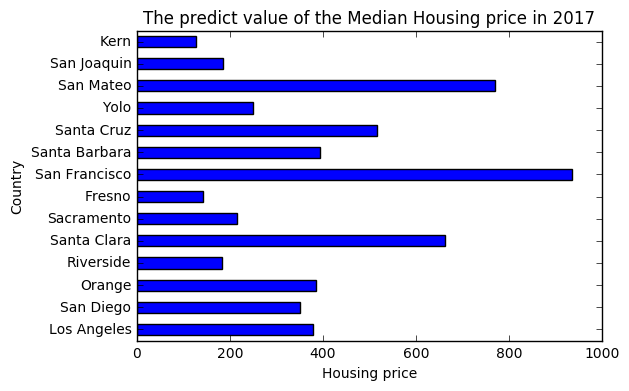

In [52]:
# Get the mean price of each county in 2017 and get the plot 
c = pd.DataFrame(Final_res_co,Country)
c["Country"] = Country
c.plot(y = 0,kind = "barh",legend = False)
plt.xlabel("Housing price")
plt.ylabel("Country")
plt.title("The predict value of the Mean Housing price in 2017")
plt.show()

# Analysis
 <strong>
 To analyze the possible factors affecting the house prices, we consider several factors to explain what the reasons cause this phenomenon. We analyze from four aspects: Consumer Psychology，Population Density & House Units, Economics factors and social factors. 
</strong>             

<em>


Let’s start with the first part: the relationship between population density&house units and house prices. We find many articles consider the population as the basic factor. Therefore, we prefer to search for the population for each county and corresponding house units. In the plot, we can see that compared with other cities, there is really large population density in San Francisco. However, the large cluster of house units is mainly centered around Los Angles. Hence, we can infer that the large population density and low house units in San Francisco will lead the house prices to go up, which consists with the predict prices in last part. 
</em>

<h2>Consumer psychology factor</h2>
<em>
Motivation:
In order to help us have a clear and deep understanding from customers'perspective, we try to find out which factors that people care about the house. </em>
<h4> Strategy:         </h4>
<em>
Since 21st century real estate company is one of the biggest real estate companies in the world, we can find out articles about the analysis of what types of house that buyers think are ideal. 
<ul>
<li>We first analyze the word frequency and the word cloud. </li>
<li>Then delete some meaningless words such as “a”, “the”, etc, and extract top 50 highest frequency words.</li> 
<li>Finally, according to those words, we could find the needs of house buyers.</li></ul>
</em>

In [56]:
import requests
link = "http://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python"
f = requests.get(link)
tree = html.fromstring(f.content)

In [57]:
#connect to a URL
website = urllib2.urlopen('http://www.century21.com/real-estate-blog/category/buyer-advice/')
#read html code
html = website.read()
#use re.findall to get all the links
links = re.findall('"(https?://www.century21.com/real-estate-blog/.*?)"', html)
links = links[16:66]

In [58]:
#append all body contents together
b = []
paragraphs = []
for link in links:
    url = link
    r = requests.get(url)
    soup = BeautifulSoup(r.content,'lxml')
    a = soup.find_all('p')
    b.append(a)

In [59]:
#tokenize sentences
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
a = str(b)
e = tknzr.tokenize(a)

In [60]:
#find the word frequency
wordfreq = [e.count(p) for p in e]
dictionary = dict(zip(e,wordfreq))
aux = [(dictionary[key], key) for key in dictionary]
aux.sort()
aux.reverse()

In [61]:
final_word = []#find the 50 most common words
aux = tuple(aux)
final_word = aux[13]+aux[25]+aux[65]+aux[71]+aux[75]+aux[83]+aux[84]+aux[101]+aux[109:115]+aux[129]+aux[131]+aux[135]+aux[137]+aux[139:145]+aux[180:190]+aux[469:473]

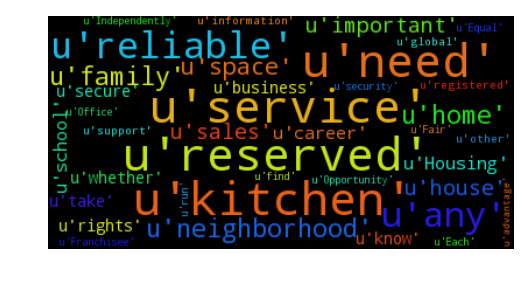

In [62]:
from os import path
from wordcloud import WordCloud

e = str(final_word)
# Generate a word cloud image
wordcloud = WordCloud().generate(e)

# Display the generated image:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(e)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<strong>
From the word-cloud, we see that the high frequency word in 21-century blog are "service", "kitchen", "career", "business", "neighborhood", "school", "space" and "secure". 
We may infer that customers care about
<ul>
<li>the service and security of their house community</li>
<li>the convenience for their work or school </li>
<li>the quality of their house<li>
</ul>
</strong>


<strong>
<h4> Suspect:</h4>
Since many people care about the distance to schools and companies, the demand for house that nearby the companies and schools will increase. So the house price that near individual's schools and companies would increase. Hence, we can guess that the place that schools and companies cluster, the house price will be high. 
</strong>

In [109]:
Country = ["Los Angeles","San Diego","Orange","Riverside","Santa Clara","Sacramento","Fresno","San Francisco","Santa Barbara","Santa Cruz","Yolo","San Mateo","San Joaquin","Kern"]
url_wi = "https://en.wikipedia.org/wiki/List_of_California_locations_by_income"
page = requests.get(url_wi)
soup = BeautifulSoup(page.content, 'html.parser')
dat  = []
data = []
dat = soup.find_all("table",attrs={"class": "wikitable sortable"})
dat_1 = dat[0].find_all("td")
re_county = []
re_name = []
for i in dat_1:
    if i.a==None:
        re_county.append(str(i.text))
    else:
        re_name.append(i.text)
re_county1 = np.asarray(re_county)
re_county2 = np.split(re_county1, 58)
data1 = pd.DataFrame(re_county2)
data1["County"] = re_name
del data1[2]
del data1[3]
data1.columns = ['population', 'population density','median family income','County']

In [64]:
de = []
for i in range(0,len(data1["County"])):
    if data1["County"][i] not in Country:
        de.append(i)
data1 = data1.drop(data1.index[de])

In [65]:
from geopy.geocoders import Nominatim
import geocoder
geolocator = Nominatim()
lat = []
lon = []
get_name = [str(i) for i in data1['County']]
for i in get_name:
    location = geocoder.google(i)
    lat.append(location.lat)
    lon.append(location.lng)

In [66]:
income = []
for i in list(data1['median family income']):
    i = i.replace("$","")
    i = i.replace(",","")
    i = int(i)
    income.append(i)
rate_in = [(float(i)/float(max(income)))*100 for i in income ]
str_rate_in = [str(i) for i in rate_in]
str_income = [str(i) for i in income ]

## Economic factor

<h4>
    We use people income and the sum of the number of five star hotels and super shopping-mall to illustrate the purchasing power of residuals. With higher purchasing power, people can afford high house price. And population income directly determine the purchasing power.Therefore, the county that have relative high purchasing power will keep a high house price. </h4>

In [67]:
def Find_loc(list_names):
    '''
    Augument: 
       Convert the location to the logitude and latitude
        
    Input:
        Location string 
        
    Output:
       float type of longitude and lagitude 
    '''
    lng = []
    lat = []
    for i in list_names:
        g = geocoder.google(str(i)+",CA")
        lat.append(g.lat)
        lng.append(g.lng)
    return lat,lng

In [68]:
# extract the data of shopping mall
dat = []
result = []
mall_name = []
mall_location = []
mall_inf_pd = []
response = requests.get('https://en.wikipedia.org/wiki/List_of_shopping_malls_in_California')
soup = BeautifulSoup(response.content, 'html.parser')# Use beautiful soup parse the data from Wikipedia.
dat = soup.find_all('div', attrs = {'id':"mw-content-text", 'class':"mw-content-ltr"})
result = dat[0].find_all('li')
for i in result:
    try:
        name  = i.find_all('a')[0].text
        location = i.find_all('a')[1].text
        mall_name.append(name)
        mall_location.append(location)
    except:
        continue
# Make it to a dataframe
mall_inf_pd = pd.DataFrame(mall_location,mall_name)
mall_inf_pd["name"] = mall_inf_pd.index
mall_inf_pd.columns = ["Location","name"]

In [69]:
# Extract the data of hotel
def hotel_search(url, numpages):
    '''
    Augument: 
        Given the base URl and the page number to get all the url of article.
        
    Input:
        URL and number of pages
        
    Output:
        URL
    
    '''
    urllist_1 = []
    for i in range(numpages):
        urllist = url + 'pg='+ str(i+1) 
        urllist_1.append(urllist)
    return urllist_1
search_list = hotel_search('http://www.luxurylink.com/inventory/main.php?kw=california&dtin=2017-04-05&dtout=2017-04-06&guests=2&nights=1&prc=&pmn=&pmx=&es=0&ot=&sort=r&pp=25&np=1&ev=0&&', 9)
hotel_name = []
hotel_loc = []
for link in search_list:
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')# Use beautiful_soup to parse hotel data from luxurylink. 
    dat = soup.find_all('div', attrs = {"class":"large-8 columns"})
    res = dat[0].find_all('li')
    for i in res:
        try:
            location  = i.h4.small.text
            name = i.h4.contents[0]
            hotel_name.append(name)
            hotel_loc.append(location)
        except:
            continue
hotel_name_pd = pd.DataFrame(hotel_name)
hotel_loc_pd = pd.DataFrame(hotel_loc)
hotel = pd.concat([hotel_loc_pd,hotel_name_pd], axis = 1)
hotel.columns = ['Location', 'Hotel Name']

In [70]:
mall_loc = list(mall_inf_pd["Location"])
hotel_loc = list(hotel["Location"])

In [71]:
loc3 = Find_loc(mall_loc)
lonlat3 = pd.DataFrame(loc3[0],loc3[1])
lonlat3[1] = lonlat3.index
loc4 = Find_loc(hotel_loc)
lonlat4 = pd.DataFrame(loc4[0],loc4[1])
lonlat4[1] = lonlat4.index
lonlat_total = pd.concat([lonlat3,lonlat4])

In [72]:
CA = (36.7783, -119.4179)
map_2 = folium.Map(CA, zoom_start=5)
# Distribution of Mall and Hotel
marker_cluster1 = folium.MarkerCluster("Mall and hotel cluster").add_to(map_2)
for each in lonlat_total.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster1)
map_2

<em>Conclusion:        
We find that many luxury hotels and super shopping-malls locate in Bay area, LA area. Simutaneously, these two areas have relatively high house price. We may guess the high purchasing power enable residuals in these areas to afford the high house price. Hence, house price in these area would keep high.</em>

In [73]:
import plotly.plotly as py
from plotly.graph_objs import *
import plotly
plotly.tools.set_credentials_file('Timmy1123', 'ohjdklZmUwhrgU1CMYp3')

In [94]:
#Heatmap for income
py.sign_in('Timmy1123', 'ohjdklZmUwhrgU1CMYp3')
trace1 = {
  "lat": lat, 
  "lon": lon, 
  "marker": {
    "size": str_rate_in, 
    "sizeref": 4
  }, 
  "mode": "markers", 
  "name": "B", 
  "text": str_income, 
  "type": "scattermapbox", 
  "uid": "469a5a"
}
data13 = Data([trace1])
layout = {
  "autosize": True, 
  "height": 511, 
  "hovermode": "closest", 
  "mapbox": {
    "bearing": 0, 
    "center": {
      "lat": 35.3116418698, 
      "lon": -118.441428557
    }, 
    "pitch": 0, 
    "zoom": 5.10790759747
  }, 
  "title": "Income in  California", 
  "width": 910
}
fig = go.Figure(data=data13, layout=layout)
py.iplot(fig)

<em>Since high population income clusters in Bay area, LA area and Santa Barbarba, people in these three areas have more purchasing power than other areas. That means people in these three area can afford higher house price, and so the high price house demand in these area is higher than the others. Therefore, it would influence the house price.</em>

## Social Factor

In [75]:
# Extract data from "4icu.org" to get the name,rank and location of University of California
school_rank = []
school_location = []
school_name = []
school_name_1 = []
response = requests.get('http://www.4icu.org/us/california/universities-california.htm')
school_doc = response.text
soup = BeautifulSoup(school_doc, 'lxml')
result = soup.find_all('div', class_ = "container")
result = result[0].find_all('table',class_= "table table-hover")
result = result[0].find_all('tr')
result = result[1:]
for i in result:
    rank = i.find_all('kbd')[0].contents[0]# get the rank
    school_rank.append(rank)
    name = i.find_all('td')[1].contents[0]# get the university name
    school_name_1.append(name)
    loc = i.find_all('td')[2].contents[0]# get the university location
    school_location.append(loc)
school_name_1 = school_name_1[0:-1]
for j in school_name_1:
    school_name.append(j.contents[0])
Name = pd.DataFrame(school_name)
Rank = pd.DataFrame(school_rank)
Location = pd.DataFrame(school_location)
school = pd.concat([Rank, Name, Location], axis = 1) # get the dataframe of university information
school.columns = ['Rank', 'School', 'Location']


In [76]:
# Extract the school location and transform it to a list.
school = school.drop(school.index[116])
school = school.drop(school.index[-1])
sch_loc = list(school["Location"])

In [77]:
loc1 = Find_loc(sch_loc)
lonlat1 = pd.DataFrame(loc1[0],loc1[1])
lonlat1[1] = lonlat1.index

In [78]:
CA = (36.7783, -119.4179)
map_1 = folium.Map(CA, zoom_start=5)
map_3 = folium.Map(CA, zoom_start=5)

In [79]:
#Distribution of Universities in California
marker_cluster = folium.MarkerCluster("School cluster").add_to(map_1)
for each in lonlat1.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster)
map_1

<em>
We can easily find out that there are two school clusters on the map. The one is around Bay area, the other is near LA area. Simutaneously, these two areas have relatively high house price. So we guess that schools may attract many students of outstate and of other counties in California settling down after they graduate from universities. With more and more people settle around school, house price that nearby universities will be high, and the school cluster will push the entire county house price. Hence, we conclude that school clusters would be an important factor for house price.
We notice that there are almost twice universities in LA area than in Bay area. However, the house price of Bay area is relatively higher than LA area. So there may be some factors that counteract the influence of universities. 
</em>

In [80]:
#Distribution of s&p company
company = pd.read_csv('Location.csv') #The location dataset is in the github
del company["Unnamed: 0"]
del company["Location"]
company = pd.concat([company['lat'], company['lon']], axis = 1)
marker_cluster2 = folium.MarkerCluster("company cluster").add_to(map_3)
for each in company.iterrows():
    folium.Marker(list((each[1][0],each[1][1]))).add_to(marker_cluster2)
map_3

<em>
We can see that there two “500 s & p company” clusters on the map. The one is around Bay area, and the other one is near LA area. Also, the price of these two area is relatively high. So we can infer from that company distribution has a significant impact on the house price. We guess the reason is that: these super companies attract people from out-state or other countries flowing into the county. As a result, the large total population pushes the house price up. Also, when comparing the house price in Bay area and LA area, the house price in Bay area is higher than in LA area. Remind that the number of schools in LA is twice more than in Bay area, but number of super companies in Bay area is twice more than those in LA area. So we can conclude the company factor contribute more to house price than school factor. The reason behind that we guess is the most important thing that determine whether people settle in a specific county is whether they can find a job.
</em>

## Population influence

In [89]:
list_names = ['Los Angeles, CA','San Diego, CA', 'Orange, CA', 'Riverside, CA', 'Santa Clara, CA', 'Sacramento, CA','Fresno, CA', 'San Francisco, CA', 'Santa Barbara, CA', 'Santa Cruz, CA', 'Yolo, CA', 'San Mateo, CA', 'San Joaquin, CA', 'Kern, CA'] 
Housing_units = ['3476718','1180806','1064642','815322','646190','560271','321955','383676','154135','105034','76090','272838','236562','289529'] 
City_Name = pd.DataFrame(list_names) 
Housing_units = pd.DataFrame(Housing_units) 
City_Housing_Units = pd.concat([City_Name, Housing_units],axis = 1) 
City_Housing_Units.columns = ['City_Name','Housing_Units'] 

In [90]:
unit = []
for i in list(City_Housing_Units["Housing_Units"]):
    i = int(i)
    unit.append(i)
rate_un = [(float(i)/float(max(unit)))*100 for i in unit ]
str_rate_unit = [str(i) for i in rate_un]
str_unit = [str(i) for i in unit ]

In [104]:
py.sign_in('Timmy1123', 'ohjdklZmUwhrgU1CMYp3')
trace1 = {
  "lat": lat, 
  "lon": lon, 
  "marker": {
    "size": str_rate_unit, 
    "sizeref": 1
  }, 
  "mode": "markers", 
  "name": "B", 
  "text": str_unit, 
  "type": "scattermapbox", 
  "uid": "469a5a"
}
data12 = Data([trace1])
layout = {
  "autosize": True, 
  "height": 511, 
  "hovermode": "closest", 
  "mapbox": {
    "bearing": 0, 
    "center": {
      "lat": 35.3116418698, 
      "lon": -118.441428557
    }, 
    "pitch": 0, 
    "zoom": 5.10790759747
  }, 
  "title": "Housing unit in  California", 
  "width": 910
}
fig = go.Figure(data=data12, layout=layout)
py.iplot(fig)

The housing unit in SF is typically small, so the lack of housing unit may also influence the price of the house.

In [118]:
po = []
for i in list(data1['population density']):
    i = i.replace(",","")
    i = float(i)
    po.append(i)
rate_po = [(float(i)/float(max(po)))*3000 for i in po ]
str_rate_po = [str(i) for i in rate_po]
str_po = [str(i) for i in po ]

In [120]:
# heatmap of population density
py.sign_in('Timmy1123', 'ohjdklZmUwhrgU1CMYp3')
trace1 = {
  "lat": lat, 
  "lon": lon, 
  "marker": {
    "size": str_rate_po, 
    "sizeref": 5
  }, 
  "mode": "markers", 
  "name": "B", 
  "text": str_po, 
  "type": "scattermapbox", 
  "uid": "469a5a"
}
data5 = Data([trace1])
layout = {
  "autosize": True, 
  "height": 511, 
  "hovermode": "closest", 
  "mapbox": {
    "bearing": 0, 
    "center": {
      "lat": 35.3116418698, 
      "lon": -118.441428557
    }, 
    "pitch": 0, 
    "zoom": 5.10790759747
  }, 
  "title": "Population density in  California", 
  "width": 910
}
fig = Figure(data=data5, layout=layout)
py.iplot(fig)

From the graph, since the size of the circle denote the population density, we can see that population density in Bay area is much more than any other counties. Therefore, we can say that population density is an important factor for Bay area's house price 

<strong>
<h2>Conclusion</h2>
In general, from the time series model, we get the mean price of 14 counties of California in 2017. We find out the house price in Bay area and LA area is higher than others. Then we focus on finding the reason that causes this phenomenon.
* From the word cloud, we find that from consumers’ perspective, their preference of living near companies or schools will push the house price.

* From the economic factor, we find that the county’s purchasing power will impact house price.

* From social factor, the distribution of company and school will impact house price, and company factor weight more.

*  From population factor, the place that with high population density and low total house units will have high house price. 

</strong>

<strong><h2>Potential Error and Improvement</h2>
* Since what we focused on is county’s median house price of California, which is a kind of macro-perspective analysis method. Therefore, we have risks of ignoring some conditions. For example, if some small areas of a specific county have high house price, but the average house price of that county is low, then we may ignore to analyze these areas.  

* Through diagnosis, we find that there are still some spaces for improvement in our time series model.

* There are many factors that cause high house price. But what we analysis is just consumer psychology, social, economic, and population factors. Therefore, we may overlook some “external” factors like immigration, and some nature factors, such as “air pollution index”.</strong>